## Разработка стратегии взаимодействия с клиентами, склонными уходить в отток, для сети  фитнес-центров <a class='tocSkip'>
### Описание проекта<a class='tocSkip'>
Сеть фитнес-центров «Культурист-датасаентист» разрабатывает стратегию взаимодействия с клиентами на основе аналитических данных. Распространённая проблема фитнес-клубов и других сервисов — отток клиентов. Как понять, что клиент больше не вернется? Можно записать в отток тех, кто попросил закрыть договор или удалил аккаунт. Однако клиенты не всегда уходят демонстративно: чаще перестают пользоваться сервисом тихо. Для фитнес-центра можно считать, что клиент попал в отток, если за последний месяц ни разу не посетил спортзал. Чтобы бороться с оттоком, отдел по работе с клиентами «Культуриста-датасаентиста» перевёл в электронный вид множество клиентских анкет. 
### Задание<a class='tocSkip'>
    
Необходимо провести анализ и подготовить план действий по удержанию клиентов, а именно:<br>
    
    1. научиться прогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;    
    2. сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства; 
    3. проанализировать основные признаки, наиболее сильно влияющие на отток;    
    4. сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами: 
            - выделить целевые группы клиентов; 
            - предложить меры по снижению оттока; 
            - определить другие особенности взаимодействия с клиентами.

### Описание данных <a class='tocSkip'>
<b>Таблица gym_churn:</b>
- 'Churn' — факт оттока в текущем месяце;
<br><br><i><b>Текущие поля в датасете:
<br>Данные клиента за предыдущий до проверки факта оттока месяц:</b></i>
- 'gender' — пол;
- 'Near_Location' — проживание или работа в районе, где находится фитнес-центр;
- 'Partner' — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);
- 'Promo_friends' — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);
- 'Phone' — наличие контактного телефона;
- 'Age' — возраст;
- 'Lifetime' — время с момента первого обращения в фитнес-центр (в месяцах).
<br><br><i><b>Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:</b></i>
- 'Contract_period' — длительность текущего действующего абонемента (месяц, 3 месяца, 6 месяцев, год);
- 'Month_to_end_contract' — срок до окончания текущего действующего абонемента (в месяцах);
- 'Group_visits' — факт посещения групповых занятий;
- 'Avg_class_frequency_total' — средняя частота посещений в неделю за все время с начала действия абонемента;
- 'Avg_class_frequency_current_month' — средняя частота посещений в неделю за предыдущий месяц;
- 'Avg_additional_charges_total' — суммарная выручка от других услуг фитнес-центра: кафе, спорт-товары, косметический и массажный салон.

### Содержание <a class='tocSkip'>

[1. Загрузка данных](#step1)

[2. Исследовательский анализ данных (EDA)](#step2)<br>

[3. Построение модели прогнозирования оттока клиентов](#step3)<br>

[4. Кластеризация клиентов](#step4)<br>

[5. Выводы и базовые рекомендации по работе с клиентами](#step5)<br>

In [1]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score
from scipy.cluster.hierarchy import dendrogram, linkage 
from sklearn.cluster import KMeans

##  1. Загрузка данных<a id="step1"></a> 

In [2]:
gym_churn=pd.read_csv('gym_churn.csv')

In [3]:
gym_churn.info()
gym_churn.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


###  Для удобства дальнейших вычислений переведем тип данных столбца "Month_to_end_contract " из float в int. <a class='tocSkip'>

In [4]:
gym_churn['Month_to_end_contract']=gym_churn['Month_to_end_contract'].astype('int')
gym_churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   int32  
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

In [5]:
gym_churn[gym_churn.duplicated()]

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn


### Выводы по таблице 'gym_churn':<a class='tocSkip'>
1. Объем таблицы 14 столбцов на 4000 строк (4000 клиентов клуба). Данные в таблице представлены 2 типами (float64(3), int64(11)). В таблице 7 номинативных (категориальных) величин (включая целевую функцию "Churn"), 7 числовых величин (4 дискретных ("Contract_period", "Age", "Month_to_end_contract" и "Lifetime"), 3 непрерывных("Avg_additional_charges_total", "Avg_class_frequency_total", "Avg_class_frequency_current_month")) 
2. Пропуски в таблице отсутствуют.
3. В таблице нет дубликатов, что хорошо.

## 2. Исследовательский анализ данных (EDA)<a id="step2"></a> 

In [6]:
gym_churn.isna().sum()

gender                               0
Near_Location                        0
Partner                              0
Promo_friends                        0
Phone                                0
Contract_period                      0
Group_visits                         0
Age                                  0
Avg_additional_charges_total         0
Month_to_end_contract                0
Lifetime                             0
Avg_class_frequency_total            0
Avg_class_frequency_current_month    0
Churn                                0
dtype: int64

### Пропущенных значений в датасете нет<a class='tocSkip'>

### Проверим соотношения столбцов, в которых содержится информация о месяцах:<a class='tocSkip'>
- длительность текущего абонемента;
- срок до окончания текущего действующего абонемента;
- время с момента первого обращения в фитнес-центр.

### Посчитаем время,  прошедшее с начала действия текущего абонемента как разность между длительностью текущего абонемента и сроком до окончания его действия. В соответствии с логикой, время с момента первого обращения в фитнес-центр 'Lifetime' не может быть меньше, чем время,  прошедшее с начала действия текущего абонемента - ведь, чтоб купить абонемент, нужно обратиться в фитнес-клуб.<a class='tocSkip'>

In [7]:
gym_churn_check=gym_churn[['Contract_period','Month_to_end_contract','Lifetime']]
gym_churn_check['Month_from_start_contract']=gym_churn_check['Contract_period']-gym_churn_check['Month_to_end_contract']
print(gym_churn_check[(gym_churn_check['Lifetime']<gym_churn_check['Month_from_start_contract'])].shape)
warnings.filterwarnings("ignore")
gym_churn_check[(gym_churn_check['Lifetime']<gym_churn_check['Month_from_start_contract'])]

(137, 4)


<ipython-input-7-0a2b0077ecc6>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gym_churn_check['Month_from_start_contract']=gym_churn_check['Contract_period']-gym_churn_check['Month_to_end_contract']


,Contract_period,Month_to_end_contract,Lifetime,Month_from_start_contract
71,12,11,0,1
72,6,5,0,1
94,6,5,0,1
95,6,5,0,1
107,12,9,1,3
...,...,...,...,...
3912,12,8,1,4
3919,12,6,1,6
3952,12,6,3,6
3972,12,8,3,4


### В представленных данных 137 клиентов (137/4000*100=3,4%), которые каким-то чудесным образом сначала купили абонемент, а потом обратились в фитнес-клуб. Хорошо бы убрать эти странные строки из таблицы, так как заменить значения в них не представляется возможным - непонятно данные в каком столбце заменять - клиент на самом деле раньше пришел в клуб ('Lifetime') или неправильно определены месяцы, оставшиеся в абонементе ('Month_to_end_contract')?<a class='tocSkip'>

### Чтобы хоть как-то уменьшить влияние этих странных данных на результаты последующих вычислений, удалим из таблицы 1% строк, в которых расхождение между 'Lifetime' и 'Month_from_start_contract' наибольшее - 3 месяца и более - всего 44 строки.<a class='tocSkip'>

In [8]:
print(gym_churn_check[gym_churn_check['Month_from_start_contract']-gym_churn_check['Lifetime']>2].shape)
gym_churn_check[gym_churn_check['Month_from_start_contract']-gym_churn_check['Lifetime']>2]

(44, 4)


,Contract_period,Month_to_end_contract,Lifetime,Month_from_start_contract
250,12,8,1,4
414,12,6,2,6
462,12,8,1,4
549,12,2,7,10
604,12,4,3,8
693,12,4,4,8
712,12,7,2,5
906,12,2,1,10
929,12,8,1,4
1023,12,4,1,8


In [9]:
gym_churn=gym_churn[gym_churn['Contract_period']-gym_churn['Month_to_end_contract']-gym_churn['Lifetime']<3]
gym_churn.shape

(3956, 14)

### Рассчитаем средние значения и стандартные отклонения признаков <a class='tocSkip'>

In [10]:
round(gym_churn.describe(),2)

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
count,3956.00,3956.00,3956.00,3956.00,3956.0,3956.00,3956.00,3956.00,3956.00,3956.00,3956.00,3956.00,3956.00,3956.00
mean,0.51,0.84,0.48,0.31,0.9,4.61,0.41,29.18,147.05,4.31,3.75,1.87,1.76,0.27
std,0.50,0.36,0.50,0.46,0.3,4.51,0.49,3.26,96.40,4.21,3.76,0.97,1.05,0.44
min,0.00,0.00,0.00,0.00,0.0,1.00,0.00,18.00,0.15,1.00,0.00,0.00,0.00,0.00
25%,0.00,1.00,0.00,0.00,1.0,1.00,0.00,27.00,68.82,1.00,1.00,1.18,0.96,0.00
50%,1.00,1.00,0.00,0.00,1.0,1.00,0.00,29.00,136.30,1.00,3.00,1.83,1.71,0.00
75%,1.00,1.00,1.00,1.00,1.0,6.00,1.00,31.00,211.22,6.00,5.00,2.53,2.50,1.00
max,1.00,1.00,1.00,1.00,1.0,12.00,1.00,41.00,552.59,12.00,31.00,6.02,6.15,1.00


In [11]:
gym_churn['Contract_period'].value_counts()

1     2207
12     920
6      829
Name: Contract_period, dtype: int64

### Cудя по значениям, в таблице:<a class='tocSkip'>
- собрано примерно одинаковое число данных по мужчинам и женщинам (mean=0.51),
- примерно половина клиентов из таблицы - сотрудники компаний-партнеров клуба (mean=0.48),
- большинство клиентов, представленных в таблице, живут или работают в районе, где находится фиитнес-клуб(mean=0.84),
- большинство клиентов предоставили контактный телефон (mean=0.9),
- менее трети пришли в клуб в рамках акции «приведи друга»(mean=0.31),
- меньше половины посещают групповые занятия (mean=0.41),
- длительность текущего действующего абонемента в среднем составляет 4,61 месяца, однако медианное значение равно 1 месяцу - половина всех представленных в таблице клиентов взяла абонемент только на 1 месяц - в клубе продаются абонементы на 1, 6 и 12 месяцев,
- средний возраст клиентов фитнес-клуба 29 лет, диапазон возрастов - от 18 до 41 года - странно, почему нет представителей более старших возрастов и детей - им физические занятия нужны (полезны) не менее, чем людям 18-40 лет,
- большинство клиентов обратилось в клуб 3-4 месяца назад, но есть и такие, кто пришел в клуб 31 месяц тому назад,
- согласно медианному значению, у большинства клиентов срок до окончания текущего действующего абонемента составляет 1 месяц - неудивительно, если у большинства взят абонемент только на 1 месяц,
- средняя частота посещений клуба в неделю составляет менее 2-ух раз, максимальная - 6 раз,
- средняя суммарная выручка от дополнительных услуг фитнес-центра - около 140 руб/клиента, макисмум 552 руб/клиента,
- 27% клиентов представленных в таблице, ушли в отток.

### Сравним средние и медианные значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался. Интересно также разбить эти данные по полу, т.к. в значениях признаков мужчин и женщин вполне могут быть отличия. Например известно, что женщины чаще посещают групповые занятия, чем мужчины<a class='tocSkip'>

In [12]:
round(gym_churn.groupby(['Churn','gender']).mean(),2)

Near_Location  Partner  Promo_friends  Phone  Contract_period  \
Churn gender                                                                  
0     0                0.87     0.54           0.36   0.91             5.67   
      1                0.87     0.52           0.35   0.90             5.66   
1     0                0.76     0.35           0.19   0.91             1.65   
      1                0.77     0.36           0.18   0.90             1.75   

              Group_visits    Age  Avg_additional_charges_total  \
Churn gender                                                      
0     0               0.46  29.92                        160.21   
      1               0.47  30.03                        157.27   
1     0               0.26  26.94                        114.73   
      1               0.28  27.03                        115.42   

              Month_to_end_contract  Lifetime  Avg_class_frequency_total  \
Churn gender                                                               
0     0                        5.29      4.68                       2.00   
      1                        5.27      4.82                       2.04   
1     0                        1.61      1.00                       1.47   
      1                        1.69      0.98                       1.48   

              Avg_class_frequency_current_month  
Churn gender                                     
0     0                                    2.00  
      1                                    2.04  
1     0                                    1.05  
      1                                    1.03

In [13]:
round(gym_churn.groupby(['Churn','gender']).median(),2)

Near_Location  Partner  Promo_friends  Phone  Contract_period  \
Churn gender                                                                  
0     0                   1        1              0      1                6   
      1                   1        1              0      1                6   
1     0                   1        0              0      1                1   
      1                   1        0              0      1                1   

              Group_visits  Age  Avg_additional_charges_total  \
Churn gender                                                    
0     0                  0   30                        149.12   
      1                  0   30                        150.83   
1     0                  0   27                        106.78   
      1                  0   27                        101.39   

              Month_to_end_contract  Lifetime  Avg_class_frequency_total  \
Churn gender                                                               
0     0                           5         4                       2.01   
      1                           5         4                       2.05   
1     0                           1         1                       1.48   
      1                           1         1                       1.51   

              Avg_class_frequency_current_month  
Churn gender                                     
0     0                                    2.01  
      1                                    2.07  
1     0                                    0.97  
      1                                    0.98

### Полученные значения позволяют сделать следующие выводы:<a class='tocSkip'>
1. Все рассматриваемые группы клиентов чаще всего или живут, или работают в районе, где находится фитнес-центр. В случае людей, не покинувших клуб, доля составляет - 87%, в случае людей, ушедших в отток - 76-77%;
2. Среди людей, оставшихся в клубе, более половины - это сотрудники компании-партнёра клуба (52-54%), среди ушедших - только 35-36% являлись сотрудниками компании-партнёра;
3. Среди клиентов, не ушедших в отток, только 35-36% пришли в клуб в рамках акции «приведи друга», для покинувших клуб клиентов эта цифра еще ниже - 18-19%;
4. Больше половины клиентов, ушедших в отток, купили абонементы на 1 месяц и в первый раз обратились в фитнес-центр месяц назад. Для постоянных клиентов характерна покупка абонемента в среднем на 6 месяцев. Любопытно, что не менее половины клиентов, не ушедших в отток, в первый раз пришли в фитнес-клуб только 4 месяца назад - либо в клубе сильная текучка, либо он не так давно открылся;
5. Гораздо мЕньше людей, покинувших клуб, ходило на групповые занятия по сравнению с людьми, оставшимися в клубе - 26-28% против 46-47%;
6. Для постоянных посетителей клуба характерен средний возраст 30 лет, для людей, не задержавшихся в клубе - 27 лет;
7. Постоянные клиенты клуба, как правило, в среднем тратят на дополнительные услуги чуть больше (150-160 руб), чем клиенты, ушедшие позднее в отток (101-115 руб);
8. Постоянные клиенты в среднем ходят в клуб стабильно 2 раза в неделю, клиенты, которые в клубе не задержатся - нестабильно 1-2 раза в неделю, а в месяц накануне своего ухода могут появляться в клубе даже не каждую неделю - согласно медиане, 0,98 посещений в неделю за предыдущий месяц.

### На основе полученных выводов можно сделать следующие гипотезы:<a class='tocSkip'>
1. В отток чаще уходят клиенты, которые живут/работают далеко от фитнес-клуба, т.к. среди ушедших в отток доля работавших/живших поблизости меньше, чем у оставшихся;
2. В отток чаще уходят люди, которые не являются сотрудниками компании-партнёра клуба;
3. Факт первоначальной записи в рамках акции «приведи друга» вполне вероятно не влияет на уход в отток - скорее, наоборот, способствует тому, что человек остается;
4. Наиболее подвержены оттоку новые клиенты, купившие абонементы на 1 месяц, т.к. среди ушедших в отток клиентов процент взявших абонемент на 1 месяц выше, чем среди постоянных клиентов;
5. Уход в отток более характерен для людей, которые не ходят на групповые занятия;
6. В отток с большей вероятностью могут уходить относительно более молодые посетители клуба;
7. Клиенты, которые не собираются покидать клуб, как правило, тратят на дополнительные услуги в среднем чуть больше, чем те, кто покинет клуб в будущем;
8. В отток чаще уходят люди нестаблиьно посещающие клуб - то 1, то 2 раза в неделю, или вообще не появляющиеся в течении недели.

### Известный факт, что на групповых занятиях женщин всегда заметно больше, чем мужчин. И хотя данные в таблицах говорят о том, что процент посещающих групповые занятия для значений пола "0" и "1" почти одинаков, но ввиду того, что для пола "1" цифры оказываются чуть больше, можно предположить, что значение пола "1" - это пол женский, тогда "0" - это мужской пол.<a class='tocSkip'>

### Для удобства построения графиков добавим столбец 'Churn_wrd' в таблицу <a class='tocSkip'>

In [14]:
gym_churn_graph=gym_churn.copy()
gym_churn_graph.loc[gym_churn_graph['Churn']==0, 'Churn_wrd']='unchurn'
gym_churn_graph.loc[gym_churn_graph['Churn']==1, 'Churn_wrd']='churn'
gym_churn_graph.sample(5)

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn,Churn_wrd
2643,1,1,0,0,1,1,1,30,158.125587,1,0,1.690530,1.532906,1,churn
1322,0,1,0,0,1,1,1,26,56.891663,1,2,2.163264,1.654511,1,churn
2779,1,1,0,0,1,6,1,28,159.366956,6,3,1.168678,1.196979,0,unchurn
1968,0,1,1,1,1,12,0,29,60.475037,12,2,1.183807,1.347358,0,unchurn
1239,1,0,0,0,0,1,0,26,150.432285,1,2,2.698218,1.849893,1,churn


### Построим столбчатые диаграммы для категориальных признаков, которые принимают значения "0" и "1". В нашей таблице всего 6 таких признаков. На диаграммах отобразим долю клиентов для, которых характерны значения "1".<a class='tocSkip'>

In [15]:
data_for_bar=round(gym_churn_graph.groupby(['Churn_wrd'])[['gender','Near_Location','Partner','Promo_friends','Phone','Group_visits']].mean(),2).stack().reset_index()
data_for_bar.columns=['Churn','features','mean']
data_for_bar

,Churn,features,mean
0,churn,gender,0.51
1,churn,Near_Location,0.77
2,churn,Partner,0.35
3,churn,Promo_friends,0.18
4,churn,Phone,0.90
5,churn,Group_visits,0.27
6,unchurn,gender,0.51
7,unchurn,Near_Location,0.87
8,unchurn,Partner,0.53
9,unchurn,Promo_friends,0.35


In [16]:
# функция autolabel() подписывает значения на графиках
def autolabel(rects, labels=None, height_factor=1.01):
    for i, rect in enumerate(rects):
        height = rect.get_height()
        if labels is not None:
            try:
                label = labels[i]
            except (TypeError, KeyError):
                label = ' '
        else:
            label = '%d' % int(height)
        ax.text(rect.get_x() + rect.get_width()/2., height_factor*height,
                '{}'.format(label),
                ha='center', va='bottom')

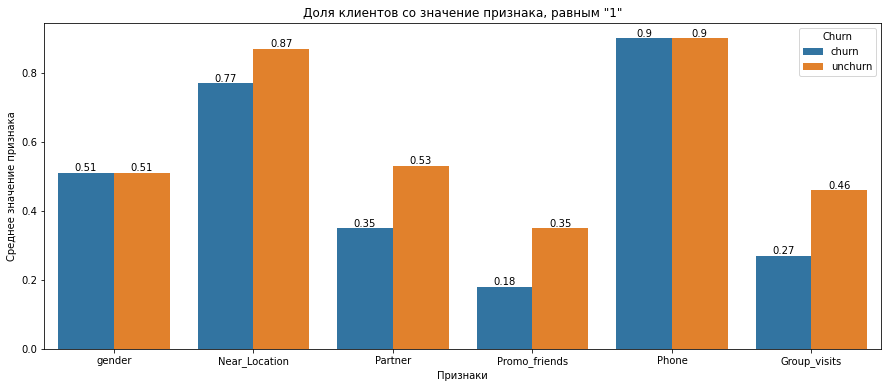

In [17]:
plt.figure(figsize=(15,6))
ax = sns.barplot(x="features", y="mean", hue="Churn", data=data_for_bar)
autolabel(ax.patches, data_for_bar['mean'], height_factor=1)
plt.ylabel('Среднее значение признака')
plt.xlabel('Признаки')
plt.title('Доля клиентов со значение признака, равным "1"')
plt.show()

### Cтолбчатые диаграммы (построенные по данным таблицы без разделения по полу) визуально повторяют те выводы, которые были сделаны на основе данных таблиц со средними значениями признаков:<a class='tocSkip'><br>
1. Гендерный состав в группах покинувших клуб клиентов и оставшихся одинаковый - и там, и там 51% составляют женщины (согласно сделанному ранее предположению, что значение пола "1" - это пол женский) - можно предположить, что пол человека никак не влияет на уход в отток;
<br><br>
2. Все рассматриваемые группы клиентов чаще всего или живут, или работают в районе, где находится фитнес-центр. В случае людей, не покинувших клуб, доля составляет - 87%, в случае людей, ушедших в отток - 77%. В отток чаще уходят клиенты, которые живут/работают далеко от фитнес-клуба, т.к. среди ушедших в отток доля работавших/живших поблизости меньше, чем у оставшихся;<br><br>
3. Среди людей, оставшихся в клубе, более половины - это сотрудники компании-партнёра клуба (53%), среди ушедших - только 35% являлись сотрудниками компании-партнёра. В отток чаще уходят люди, которые не являются сотрудниками компании-партнёра клуба;<br><br>
4. Среди клиентов, не ушедших в отток, только 35% пришли в клуб в рамках акции «приведи друга», для покинувших клуб клиентов эта цифра еще ниже - 18%. Факт первоначальной записи в рамках акции «приведи друга» вполне вероятно не влияет на уход в отток, скорее наоборот, людям нравится ходить в клуб в компании с друзьями;<br><br>
5. Гораздо мЕньше людей, покинувших клуб, ходило на групповые занятия по сравнению с людьми, оставшимися в клубе - 27% против 46%. Уход в отток более характерен для людей, которые не ходят на групповые занятия;<br><br>
6. В обеих рассматриваемых группах бОльшая часть клиентов (90%) оставляла данные своего контактного телефона - сомнительно, что этот признак способен влиять на отток.<br>

### Построим гистограммы распределения дискретных количественных признаков<a class='tocSkip'>
Численное превалирование в исходной таблице клинетов, которые не покинули клуб ('unchurn', 100-27=73%), хорошо видно на всех гистограммах. 

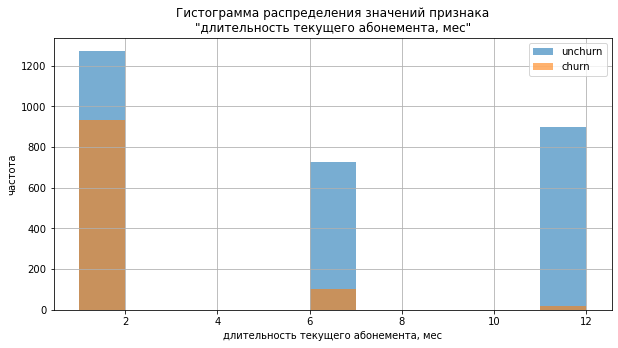

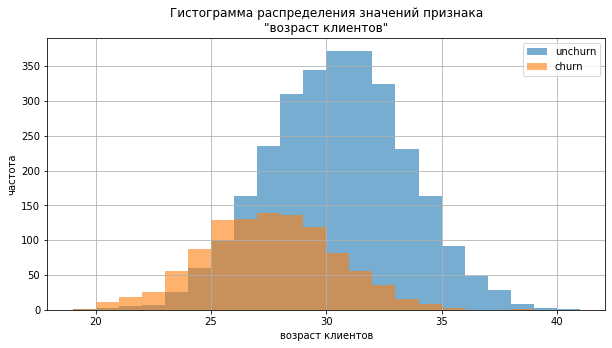

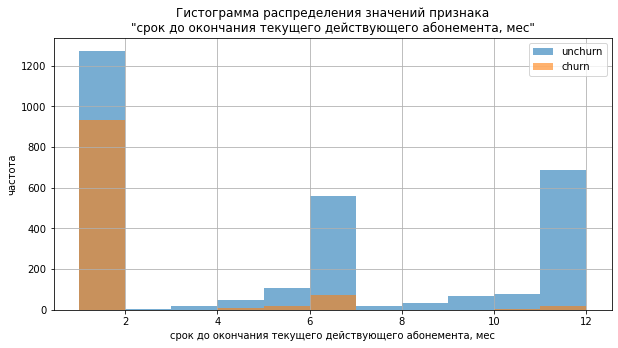

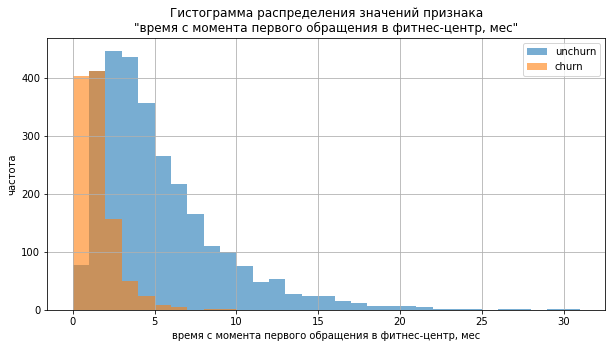

In [18]:
feature_qty_list=['Contract_period','Age','Month_to_end_contract','Lifetime']
feature_qty_names_list=['длительность текущего абонемента, мес','возраст клиентов','срок до окончания текущего действующего абонемента, мес','время с момента первого обращения в фитнес-центр, мес']
data_unchurn=gym_churn_graph[gym_churn_graph['Churn']==0]
data_churn=gym_churn_graph[gym_churn_graph['Churn']==1]
for i in range(0,4):
    plt.figure(figsize=(10,5))
    bins=range(min(data_unchurn[feature_qty_list[i]]), max(data_unchurn[feature_qty_list[i]]) + 1, 1)
    plt.hist(data_unchurn[feature_qty_list[i]], bins=bins, alpha=0.6, label='unchurn') 
    plt.hist(data_churn[feature_qty_list[i]],  bins=bins, alpha=0.6, label='churn')  
    plt.ylabel('частота')
    plt.xlabel(feature_qty_names_list[i])
    plt.title('Гистограмма распределения значений признака\n"'+feature_qty_names_list[i]+'"')
    plt.grid()
    plt.legend()
    plt.show()

### Построим гистограммы и графики плотности распределения всех количественных признаков - оси у будет соответствовать плотность вероятности.<a class='tocSkip'>
Используем коэффициент для того, чтобы одинаково разбивать значения на бины.

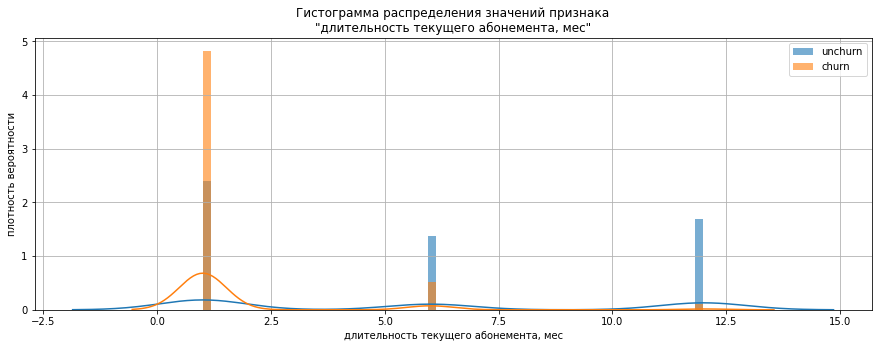

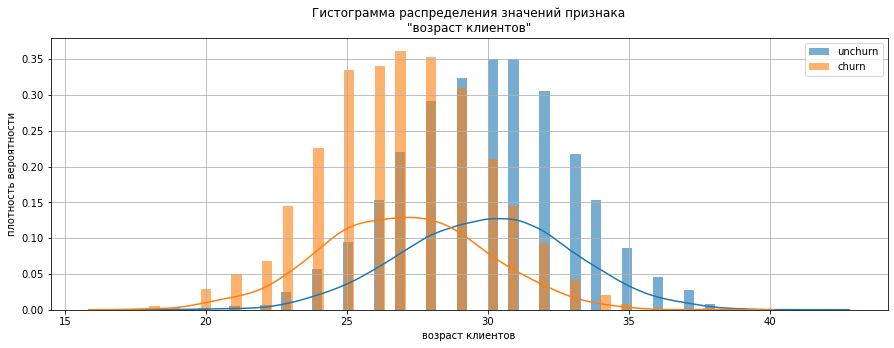

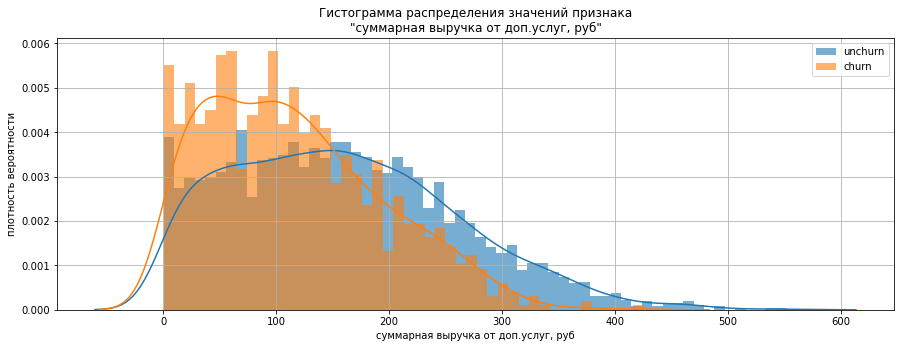

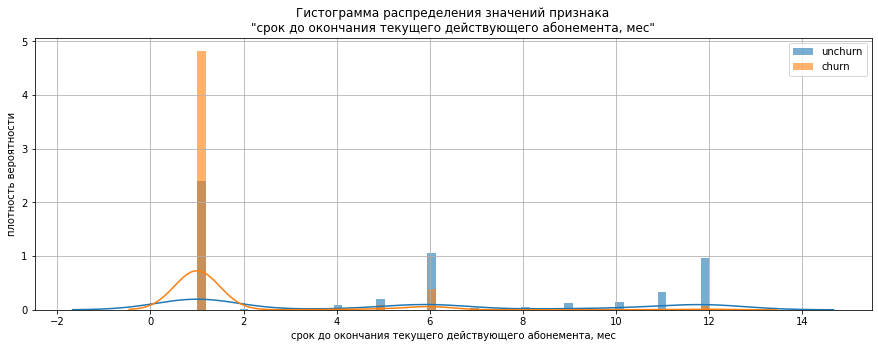

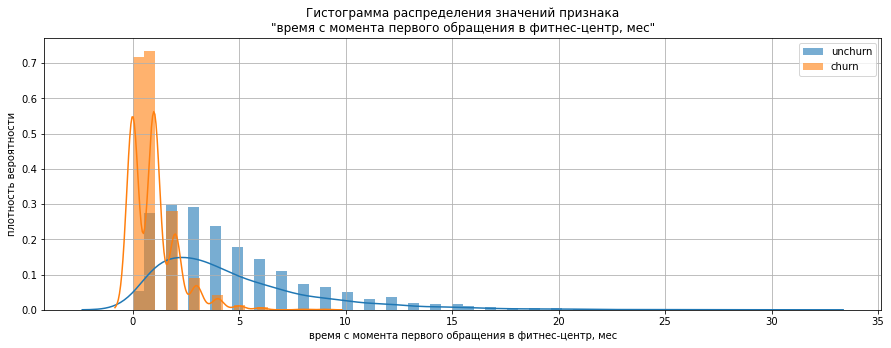

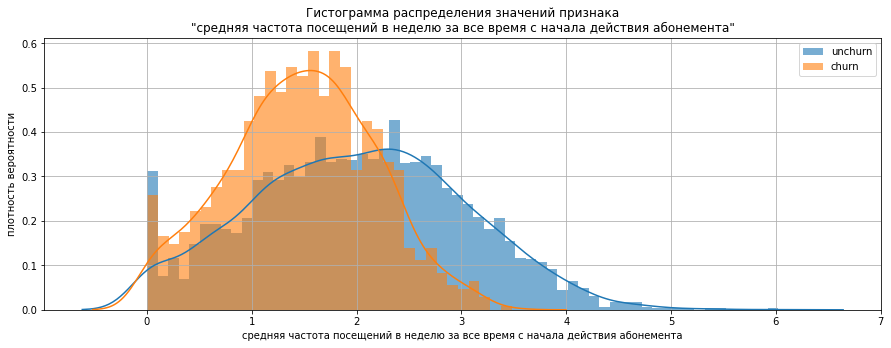

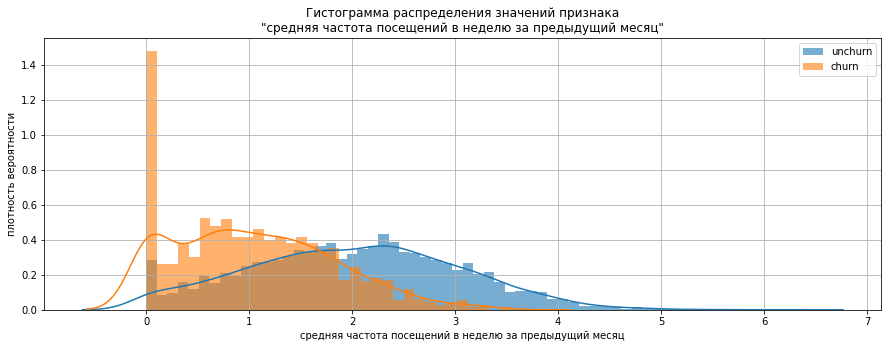

In [19]:
feature_qty_list=['Contract_period','Age','Avg_additional_charges_total','Month_to_end_contract','Lifetime','Avg_class_frequency_total','Avg_class_frequency_current_month']
feature_qty_names_list=['длительность текущего абонемента, мес','возраст клиентов','суммарная выручка от доп.услуг, руб','срок до окончания текущего действующего абонемента, мес','время с момента первого обращения в фитнес-центр, мес','средняя частота посещений в неделю за все время с начала действия абонемента','средняя частота посещений в неделю за предыдущий месяц']
data_unchurn=gym_churn_graph[gym_churn_graph['Churn']==0]
data_churn=gym_churn_graph[gym_churn_graph['Churn']==1]
for i in range(0,7):
    plt.figure(figsize=(15,5))
    koeff=max(data_unchurn[feature_qty_list[i]])/max(data_churn[feature_qty_list[i]])
    sns.distplot(data_unchurn[feature_qty_list[i]], bins=60, hist_kws={'alpha':0.60}, label='unchurn') 
    sns.distplot(data_churn[feature_qty_list[i]], bins=int(60/koeff), hist_kws={'alpha':0.60}, label='churn')  
    plt.ylabel('плотность вероятности')
    plt.xlabel(feature_qty_names_list[i])
    plt.title('Гистограмма распределения значений признака\n"'+feature_qty_names_list[i]+'"')
    plt.legend()
    plt.grid()
    plt.show()

### Сведем статистику по признакам с разбивкой по факту ухода/не ухода в отток в одну таблицу<a class='tocSkip'>

In [20]:
round(gym_churn_graph.groupby(['Churn_wrd'])[feature_qty_list].agg(['mean','median','std']),2).stack().reset_index()

,Churn_wrd,level_1,Contract_period,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month
0,churn,mean,1.70,26.99,115.08,1.65,0.99,1.47,1.04
1,churn,median,1.00,27.00,103.81,1.00,1.00,1.49,0.98
2,churn,std,2.08,2.89,77.76,1.95,1.11,0.70,0.77
3,unchurn,mean,5.67,29.97,158.71,5.28,4.75,2.02,2.02
4,unchurn,median,6.00,30.00,150.22,5.00,4.00,2.03,2.04
5,unchurn,std,4.69,3.01,99.86,4.39,3.88,1.02,1.02


### Вывод по гистограммам:<a class='tocSkip'>
1. Больше половины клиентов, ушедших в отток, купили абонементы на 1 месяц и в первый раз обратились в фитнес-центр не более, чем месяц назад. БОльшая часть постоянных клиентов предпочитают также покупать абонементы на 1 месяц, но т.к. среди них также велика доля таких, которые приобретают абонементы на 6 и 12 месяцев, то среднее и медиана по показателю "Contract_period" для них оказываются равны 6 мес. Распределение времени с момента первого обращения в фитнес-центр для постоянных и не задержавшихся клиентов скошены вправо и напоминают распределение Пуассона - данные имеют выбросы;
2. Для постоянных посетителей клуба характерен средний возраст 30 лет, для людей, не задержавшихся в клубе - 27 лет. В обоих случаях распределения возрастов имеют вид нормального распределения со средними, смещенными друг относительно друга на 3 года, и примерно одинаковыми значениями стандартных отклонений (3 года);
3. Распределения суммарной выручки от доп.услуг для обеих групп клиентов также скошены вправо и напоминают распределение Пуассона - средние значения смещены друг относительно друга почти на 44 рубля (115 руб - ушедшие клиенты, 159 - оставшиеся), разброс значений для постоянных клиентов больше, чем у ушедших (стандартное отклонение для ушедших в отток - 78 руб, для оставшихся - 100 руб)
4. Распределение средней частоты посещений в неделю для обеих групп клиентов похоже на нормальное распределение, если не принимать во внимание большое количество клиентов, которые не ходят в клуб совсем - особенно много таких людей оказывается при анализе посещений за предыдущий месяц среди тех, кто в конце концов покинул клуб. Вероятно, для анализа оттока более показателен признак частоты посещений за предыдущий месяц. Средние значения распределений стремятся к следующим величинам: для ушедших в отток - к 1, для оставшихся - к 2 посещениям в неделю. Разброс значений признака оказывается чуть больше у постоянных клиентов клуба - 1,02 против 0,7-0,77.

### Построим матрицу корреляций<a class='tocSkip'>

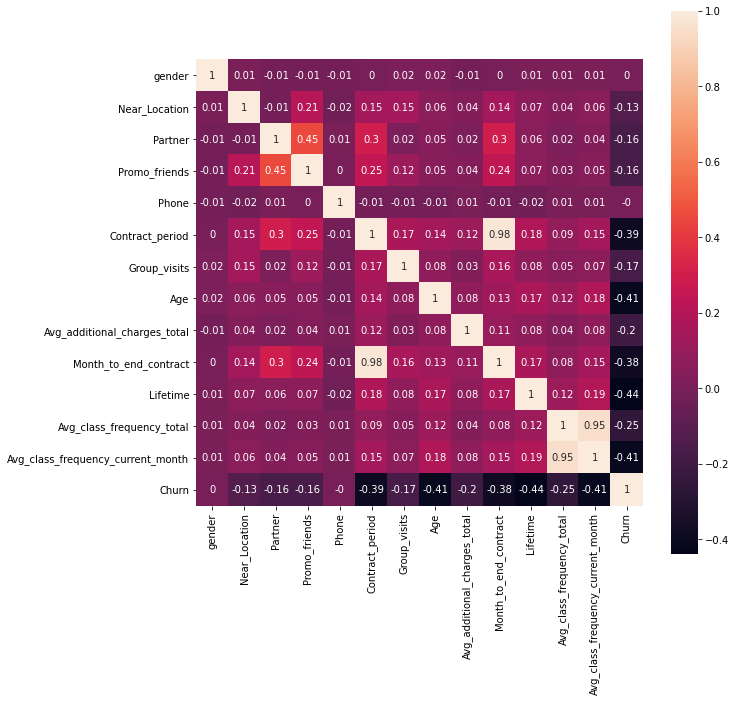

In [21]:
cm = round(gym_churn.corr(),2)  #вычисляем матрицу корреляций
plt.figure(figsize=(10,10))
#нарисуем тепловую карту с подписями для матрицы корреляций
sns.heatmap(cm, annot = True, square=True) 
ax.set_ylim(10, 0) #корректировка "рваных" полей heatmap в последней версии библиотеки
plt.show()

### Выводы по матрице корреляций:<a class='tocSkip'>
1. Имеет место слабая корреляция целевой переменной со следующими признаками:
    - 'Lifetime' — время с момента первого обращения в фитнес-центр(-0,44);
    - 'Avg_class_frequency_current_month' - средняя частота посещений в неделю за предыдущий месяц (-0,41);
    - 'Age' — возраст (-0,41);
    - 'Contract_period' — длительность текущего действующего абонемента (-0,39);
    - 'Month_to_end_contract' — срок до окончания текущего действующего абонемента (-0,38);<br><br>
Для остальных признаков характерна очень слабая корреляция с целевой переменной. <br><br>
2. Все признаки имеют отрицательную корреляцию с целевой переменной, т.е., чем меньше признак, тем вероятнее, что целевая переменная "Churn" будет равен 1.<br><br>
2. Признаки 'gender' и 'Phone' не коррелируют с целевой переменной - предположение об этом позволили сделать ранее столбчатые диаграммы этих признаков.<br><br>
3. Пары признаков 'Contract_period' - 'Month_to_end_contract'  и  'Avg_class_frequency_total' - 'Avg_class_frequency_current_month' очень сильно коррелируют между собой (0,98 и 0,95), что предсказуемо.<br><br>
4. Слабая положительная корреляция характерна для пары признаков 'Partner' и 'Promo_friends' - 0,45.

## Выводы:<a class='tocSkip'>
1. В представленных данных оказалось 137 клиентов (3,4%), которые каким-то чудесным образом сначала купили абонемент, а потом обратились в фитнес-клуб. Так как заменить странные значения в строках затруднительно - непонятно данные в каком столбце менять - клиент на самом деле раньше пришел в клуб ('Lifetime') или неправильно определены месяцы, оставшиеся в абонементе ('Month_to_end_contract'), то было решено удалить из таблицы 1% строк, в которых расхождение между 'Lifetime' и 'Month_from_start_contract' наибольшее - 3 месяца и более - всего 44 строки.<br><br>

2. На основе рассчитанных средних значений, медианных значений и стандартных отклонений признаков были сделаны следующие выводы о данных в исходной таблице:
    1. В исходном датасете собрано примерно одинаковое число данных по мужчинам и женщинам (mean=0.51),
    2. Примерно половина клиентов из таблицы - сотрудники компаний-партнеров клуба (mean=0.48),
    3. Большинство клиентов, представленных в таблице, живут или работают в районе, где находится фиитнес-клуб(mean=0.84),
    4. Большинство клиентов предоставили контактный телефон (mean=0.9),
    5. Менее трети клиентов пришли в клуб в рамках акции «приведи друга»(mean=0.31),
    6. Меньше половины клиентов посещают групповые занятия (mean=0.41),
    7. Длительность текущего действующего абонемента в среднем составляет 4,61 месяца, однако медианное значение равно 1 месяцу - половина всех представленных в таблице клиентов взяла абонемент только на 1 месяц - в клубе продаются абонементы на 1, 6 и 12 месяцев,
    8. Средний возраст клиентов фитнес-клуба 29 лет, диапазон возрастов - от 18 до 41 года - почему-то нет представителей более старших возрастов и детей - им физические занятия нужны (полезны) не менее, чем людям 18-40 лет,
    9. Большинство клиентов обратилось в клуб 3-4 месяца назад, но есть и такие, кто пришел в клуб 31 месяц тому назад,
    10. Согласно медианному значению, у большинства клиентов срок до окончания текущего действующего абонемента составляет 1 месяц - неудивительно, если у большинства взят абонемент только на 1 месяц,
    11. Средняя частота посещений клуба в неделю составляет менее 2-ух раз, максимальная - 6 раз,
    12. Средняя суммарная выручка от дополнительных услуг фитнес-центра - около 140 руб/клиента, макисмум 552 руб/клиента,
    13. 27% клиентов представленных в таблице, ушли в отток.<br><br>

3. На основе рассчитанных средних и медианных значений, построенных диаграмм по рассматриваемым признакам с разбивкой по признаку "ушел/не ушел в отток" были сделаны следующие выводы:
    1. Гендерный состав в группах покинувших клуб клиентов и оставшихся одинаковый - и там, и там 51% составляют женщины (согласно сделанному ранее предположению, что значение пола "1" - это пол женский);
    2. Все рассматриваемые группы клиентов чаще всего или живут, или работают в районе, где находится фитнес-центр. В случае людей, не покинувших клуб, доля составляет - 87%, в случае людей, ушедших в отток - 77%;
    3. Среди людей, оставшихся в клубе, более половины - это сотрудники компании-партнёра клуба (53%), среди ушедших - только 35% являлись сотрудниками компании-партнёра;
    4. Среди клиентов, не ушедших в отток, только 35% пришли в клуб в рамках акции «приведи друга», для покинувших клуб клиентов эта цифра еще ниже - 18%;
    5. В обеих рассматриваемых группах бОльшая часть клиентов (90%) оставляла данные своего контактного телефона;
    6. Больше половины клиентов, ушедших в отток, купили абонементы на 1 месяц и в первый раз обратились в фитнес-центр не более, чем 1 месяц назад. БОльшая часть постоянных клиентов (не ушедших в отток) предпочитают также покупать абонементы на 1 месяц, но т.к. среди них также велика доля таких, которые приобретают абонементы на 6 и 12 месяцев, то среднее и медиана по показателю "Contract_period" для них оказываются равны 6 мес. Интересно, что не менее половины клиентов, не ушедших в отток, в первый раз пришли в фитнес-клуб только 4 месяца назад - либо в клубе сильная текучка, либо он не так давно открылся. Распределение времени с момента первого обращения в фитнес-центр для постоянных и не задержавшихся клиентов скошены вправо и напоминают распределение Пуассона - данные имеют выбросы;
    7. Гораздо мЕньше людей, среди в итоге покинувших клуб, ходило на групповые занятия по сравнению с людьми, оставшимися в клубе - 27% против 46%;
    8. Для постоянных посетителей клуба характерен средний возраст 30 лет, для людей, не задержавшихся в клубе - 27 лет. В обоих случаях распределения возрастов имеют вид нормального распределения со средними, смещенными друг относительно друга на 3 года, и примерно одинаковыми значениями стандартных отклонений (3 года);
    9. Распределения суммарной выручки от доп.услуг для обеих групп клиентов также скошены вправо и напоминают распределение Пуассона - средние значения смещены друг относительно друга почти на 44 рубля (115 руб - ушедшие клиенты, 159 - оставшиеся), разброс значений для постоянных клиентов больше, чем у ушедших (стандартное отклонение для ушедших в отток - 78 руб, для оставшихся - 100 руб);
    10. Распределение средней частоты посещений в неделю для обеих групп клиентов похоже на нормальное распределение, если не принимать во внимание большое количество клиентов, которые не ходят в клуб совсем - особенно много таких людей оказывается при анализе посещений за предыдущий месяц среди тех, кто в конце концов покинул клуб. Вероятно, для анализа оттока более показателен признак частоты посещений за предыдущий месяц. Средние значения распределений стремятся к следующим величинам: для ушедших в отток - к 1, для оставшихся - к 2 посещениям в неделю. Разброс значений признака оказывается чуть больше у постоянных клиентов клуба - 1,02 против 0,7-0,77 у ушедших.
<br><br> 
    
4. На основе полученных выводов были выдвинуты следующие гипотезы:
    1. В отток чаще уходят клиенты, которые живут/работают далеко от фитнес-клуба, т.к. среди ушедших в отток доля работавших/живших поблизости меньше, чем у оставшихся;
    2. В отток чаще уходят люди, которые не являются сотрудниками компании-партнёра клуба;
    3. Факт первоначальной записи в рамках акции «приведи друга» вполне вероятно влияет на неуход в отток - людям нравится ходить в клуб в компании с друзьями;
    4. Наиболее подвержены оттоку новые клиенты, пришедшие в клуб 1 месяц назад и купившие абонементы на 1 месяц;
    5. Уход в отток более характерен для людей, которые не ходят на групповые занятия;
    6. В отток с большей вероятностью могут уходить относительно более молодые посетители клуба;
    7. Клиенты, которые не собираются покидать клуб, как правило, тратят на дополнительные услуги в среднем чуть больше, чем те, кто покинет клуб в будущем;
    8. В отток чаще уходят люди нестаблиьно посещающие клуб - то 1, то 2 раза в неделю, или вообще не появляющиеся в течении недели. Клиенты, остающиеся в клубе, в среднем стабильно 2 раза в неделю ходят в клуб;
    9. Пол человека никак не влияет на уход в отток;
    10. Маловероятно, что признак 'Phone' — наличие контактного телефона - способен влиять на отток.
<br><br>
    
5. Опираясь на матрицу корреляций, кажется логичным для дальнейшего построения моделей выбрать только часть признаков:<br><br>
      1. Не использовать признаки'gender' и 'Phone', т.к. они не коррелируют с целевой переменной, а значит вряд ли влияют на нее;<br><br>
      2. Выбрать только по одному признаку из двх пар 'Contract_period' - 'Month_to_end_contract'  и  'Avg_class_frequency_total' - 'Avg_class_frequency_current_month', в которых признаки очень сильно коррелируют между собой (0,98 и 0,95). Оставим для построения моделей признак 'Contract_period', как более конкретный и относительно постоянный признак, характеризующий покупателя. 'Month_to_end_contract' меняется каждый месяц. Также оставим для дальнейшего построения моделей признак 'Avg_class_frequency_current_month', т.к. разница в средних значениях этого признака для оставшихся и ушедших покупателей больше, чем у признака 'Avg_class_frequency_total',<br><br>
      3. Для дальнейшего построения моделей рекомендуется выбрать следующие признаки:
            1. 'Near_Location', 
            2. 'Partner', 
            3. 'Promo_friends',
            4. 'Group_visits', 
            5. 'Age',
            6. 'Contract_period',
            7. 'Avg_additional_charges_total',  
            8. 'Lifetime',
            9. 'Avg_class_frequency_current_month'.

## 3. Построение модели прогнозирования оттока клиентов<a id="step3"></a> 

### Построим модель бинарной классификации клиентов, где целевой признак — факт оттока клиента в следующем месяце:<a class='tocSkip'>
1. Разделим наши данные на признаки (матрица X) и целевую переменную (y),
2. Разделим модель на обучающую и валидационную выборку в соотноешнии 4:1,
3. Создадим и обучим модель для логистической регрессии и посчитаем метрики accuracy, precision и recall для этой модели на валидационной выборке,
4. Создадим и обучим модель для случайного леса и посчитаем метрики accuracy, precision и recall для этой модели на валидационной выборке.
### Расчеты сделаем дважды: с использованием всех признаков и признаков, рекомендованных в предыдущем разделе.<a class='tocSkip'>

In [22]:
# определим функцию, которая будет выводить наши метрики
def print_all_metrics(y_true, y_pred, y_proba, title = 'Метрики классификации'):
    print(title)
    print('\tAccuracy: {:.2f}'.format(accuracy_score(y_true, y_pred)))
    print('\tPrecision: {:.2f}'.format(precision_score(y_true, y_pred)))
    print('\tRecall: {:.2f}'.format(recall_score(y_true, y_pred)))
    print('\tF1: {:.2f}'.format(f1_score(y_true, y_pred)))

### Расчет с использованием всех признаков<a class='tocSkip'>

In [23]:
features_list=gym_churn.drop('Churn', axis = 1).columns
features_list

Index(['gender', 'Near_Location', 'Partner', 'Promo_friends', 'Phone',
       'Contract_period', 'Group_visits', 'Age',
       'Avg_additional_charges_total', 'Month_to_end_contract', 'Lifetime',
       'Avg_class_frequency_total', 'Avg_class_frequency_current_month'],
      dtype='object')

In [24]:
# разделим наши данные на признаки (матрица X) и целевую переменную (y)
X = gym_churn[features_list]
y = gym_churn['Churn']
# разделим модель на обучающую и валидационную выборку в соотноешнии 4:1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0,stratify=y)

# зададим алгоритм для нашей модели
model = LogisticRegression() 
# обучим модель
model.fit(X_train,y_train)
# воспользуемся уже обученной моделью, чтобы сделать прогнозы
predictions = model.predict(X_test) 
probabilities =model.predict_proba(X_test)[:,1] 
warnings.filterwarnings("ignore")
# выведем метрики для полученного прогноза
print_all_metrics(y_test, predictions, probabilities, title = 'Метрики для модели логистической регрессии:')

# зададим алгоритм для новой модели на основе случайного леса
rf_model =RandomForestClassifier(n_estimators = 100,random_state = 0) 
# обучим модель случайного леса
rf_model.fit(X_train, y_train)
# воспользуемся уже обученной моделью, чтобы сделать прогнозы
rf_predictions =rf_model.predict(X_test) 
rf_probabilities = rf_model.predict_proba(X_test)[:,1]
warnings.filterwarnings("ignore")
# выведем метрики
print_all_metrics(y_test, rf_predictions, rf_probabilities, title = 'Метрики для модели случайного леса:')

Метрики для модели логистической регрессии:
	Accuracy: 0.91
	Precision: 0.87
	Recall: 0.80
	F1: 0.83
Метрики для модели случайного леса:
	Accuracy: 0.91
	Precision: 0.84
	Recall: 0.81
	F1: 0.82


### Расчет с использованием признаков, рекомендованных в предыдущем разделе.<a class='tocSkip'>

In [25]:
features_list=['Near_Location', 'Partner', 'Promo_friends', 
       'Group_visits', 'Age','Contract_period',
       'Avg_additional_charges_total',  'Lifetime',
       'Avg_class_frequency_current_month']

In [26]:
# разделим наши данные на признаки (матрица X) и целевую переменную (y)
X = gym_churn[features_list]
y = gym_churn['Churn']
# разделим модель на обучающую и валидационную выборку в соотноешнии 4:1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0,stratify=y)

# зададим алгоритм для нашей модели
model = LogisticRegression() 
# обучим модель
model.fit(X_train,y_train)
# воспользуемся уже обученной моделью, чтобы сделать прогнозы
predictions = model.predict(X_test) 
probabilities =model.predict_proba(X_test)[:,1] 
warnings.filterwarnings("ignore")
# выведем метрики для полученного прогноза
print_all_metrics(y_test, predictions, probabilities, title = 'Метрики для модели логистической регрессии:')

# зададим алгоритм для новой модели на основе случайного леса
rf_model =RandomForestClassifier(n_estimators = 100,random_state = 0) 
# обучим модель случайного леса
rf_model.fit(X_train, y_train)
# воспользуемся уже обученной моделью, чтобы сделать прогнозы
rf_predictions =rf_model.predict(X_test) 
rf_probabilities = rf_model.predict_proba(X_test)[:,1]
warnings.filterwarnings("ignore")
# выведем метрики
print_all_metrics(y_test, rf_predictions, rf_probabilities, title = 'Метрики для модели случайного леса:')

Метрики для модели логистической регрессии:
	Accuracy: 0.91
	Precision: 0.82
	Recall: 0.83
	F1: 0.83
Метрики для модели случайного леса:
	Accuracy: 0.90
	Precision: 0.83
	Recall: 0.79
	F1: 0.81


## Выводы:<a class='tocSkip'>
1. Модели, которые использовали все признаки, изначально предложенные в таблице, показали лучшие результаты, чем модели с отобранными признаками. Не очень понятно, почему получился такой результат, ведь среди признаков есть сильно коррелирующие между собой, а, в частности, линейные модели неустойчивы в случае взаимной корреляции признаков.
2. В обоих экспериментах логистическая регрессия показала лучшие результаты, чем случайный лес. Вероятно, при более тонкой настройке модели случайного леса (количество деревьев, число объектов в листьях и т.д.) можно было бы добиться лучших результатов.
3. В данном случае наиболее важным показателем представляется полнота Recall, поскольку нам нужно обнаружить по-максимуму всех клиентов, которые потенциально могут уйти в отток. Наилучшее значение этого показателя (0,83) достигается при использовании части признаков в модели логистической регрессии и означает, что из 100 определенных моделью клиентов, которые потенциально могут уйти в отток, на самом деле покинут клуб 83 человека.

## 4. Кластеризация клиентов<a id="step4"></a> 

### Проведем кластеризацию объектов (клиентов) с использованием всех признаков:<a class='tocSkip'>
    1. Выделим данные с признаками (матрица X),
    2. Стандартизируем данные,
    3. Построим матрицу расстояний linked,
    4. Нарисуем дендрограмму,
    5. Обучим модель кластеризации на основании алгоритма K-Means и спрогнозируем кластеры клиентов. За число кластеров примем n=5. Сохраним метки кластера в поле 'cluster' нашего датасета,
    6. Выведем статистику по средним и медианным значениям наших признаков по каждому кластеру (в т.ч. посчитаем долю оттока, как среднее по столбцу 'Churn'),
    7. Построим распределения признаков для кластеров.

In [27]:
features_list=gym_churn.drop('Churn', axis = 1).columns
features_list

Index(['gender', 'Near_Location', 'Partner', 'Promo_friends', 'Phone',
       'Contract_period', 'Group_visits', 'Age',
       'Avg_additional_charges_total', 'Month_to_end_contract', 'Lifetime',
       'Avg_class_frequency_total', 'Avg_class_frequency_current_month'],
      dtype='object')

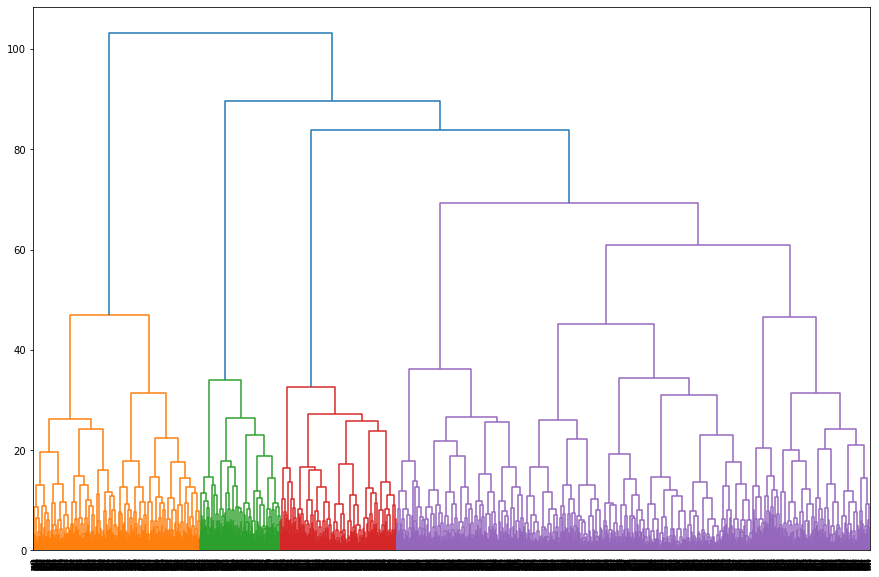

In [28]:
# Выделим данные с признаками (матрица X) 
X = gym_churn[features_list]
# стандартизируем данные
sc = StandardScaler()
X_sc = sc.fit_transform(X)
# построим матрицу расстояний
linked = linkage(X_sc, method = 'ward') 
# Нарисуем дендрограмму
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.show() 

### Исходя из полученной дендрограммы, можно было бы выделить 6 или 4 кластера, однако, согласно заданию, зададим 5 кластеров<a class='tocSkip'>

In [29]:
# задаём модель k_means с числом кластеров 5
km = KMeans(n_clusters = 5,random_state = 26)
# прогнозируем кластеры для наблюдений (алгоритм присваивает им номера от 0 до 4)
labels =  km.fit_predict(X_sc)
# сохраним метки кластера в поле 'cluster' нашего датасета
gym_churn['cluster'] = labels
gym_churn

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn,cluster
0,1,1,1,1,0,6,1,29,14.227470,5,3,0.020398,0.000000,0,4
1,0,1,0,0,1,12,1,31,113.202938,12,7,1.922936,1.910244,0,2
2,0,1,1,0,1,1,0,28,129.448479,1,2,1.859098,1.736502,0,1
3,0,1,1,1,1,12,1,33,62.669863,12,2,3.205633,3.357215,0,2
4,1,1,1,1,1,1,0,26,198.362265,1,3,1.113884,1.120078,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,1,1,1,0,1,12,0,33,2.406023,12,8,2.284497,2.349070,0,2
3996,0,1,0,0,1,1,1,29,68.883764,1,1,1.277168,0.292859,1,1
3997,1,1,1,1,1,12,0,28,78.250542,11,2,2.786146,2.831439,0,2
3998,0,1,1,1,1,6,0,32,61.912657,5,3,1.630108,1.596237,0,2


In [30]:
# выведем статистику по медианным значениям наших признаков по каждому кластеру
round(gym_churn.groupby('cluster').median(),2).reset_index()

,cluster,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,0,1,1,0,0,1,1,0,30,151.85,1,4,2.71,2.70,0
1,1,0,1,0,0,1,1,0,28,118.51,1,1,1.26,1.01,1
2,2,1,1,1,1,1,12,1,30,156.83,11,4,1.99,1.99,0
3,3,0,0,0,0,1,1,0,29,125.00,1,2,1.60,1.43,0
4,4,1,1,0,0,0,1,0,29,138.02,1,3,1.82,1.64,0


In [31]:
# выведем статистику по средним значениям наших признаков по каждому кластеру
data_for_bar_clust=round(gym_churn.groupby('cluster').mean(),2).reset_index()
data_for_bar_clust

,cluster,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,0,0.55,0.98,0.37,0.25,1.0,2.59,0.46,30.10,162.20,2.42,4.89,2.81,2.81,0.07
1,1,0.49,1.00,0.34,0.23,1.0,1.94,0.34,28.15,130.54,1.87,2.40,1.23,1.00,0.52
2,2,0.51,0.95,0.77,0.58,1.0,10.92,0.55,29.97,161.34,10.11,4.85,1.97,1.96,0.03
3,3,0.50,0.00,0.46,0.08,1.0,2.28,0.22,28.49,135.45,2.16,2.79,1.66,1.47,0.45
4,4,0.53,0.86,0.47,0.31,0.0,4.70,0.42,29.29,144.74,4.45,3.96,1.85,1.71,0.27


### Выводы по таблицам:<a class='tocSkip'>
1. Согласно столбцу "Churn", минимальный отток клиентов характерен для кластеров 0 и 2 - 7 и 3% соответственно. Максимальный отток клиентов у кластеров 1 и 3 - 52 и 45% соответственно; <br><br>
2. По гендерному признаку во всех кластерах мужчин и женщин приблизительно 50/50. Хотя в кластерах с минимальным оттоком (№ 0 и 2) женщин чуть побольше (55 и 51%), чем в кластерах с максимальным оттоком (№ 1 и 3 - 49 и 50%) - при условии, что за женщин мы приняли значение 1 в столбце "gender";<br><br>
3. Любопытно, что, хотя для кластеров № 1 и 3 характерен максимальный отток. но в кластере № 3 вообще нет клиентов, которые живут или работают поблизости от клуба, в то время, как в кластере № 1 100% таких клиентов;<br><br>
4. В большинстве кластеров меньше половины клиентов являются сотрудниками компании-партнёра клуба, и только в кластере № 2 77% таких клиентов;<br><br>
5. Схожая доля клиентов использовала промо-код от знакомого при оплате первого абонемента (23-25%) как в кластере с высокой долей оттока (№ 1), так и в кластере с низкой долей оттока (№ 0);<br><br>
6. Всех клиентов, не пожелавших оставить номер контактного телефона алгоритм отправил в кластер № 4;<br><br>
7. Согласно данным по кластеру № 2, клиенты вряд ли вскоре покинут клуб, если купили абонемент на длительный срок - в среднем не меньше, чем на 10 месяцев (на 12 месяцев по медианному значению). Хотя покупка абонемента на небольшой срок (2,6 месяца в среднем и 1 месяц, согласно медиане, для клиентов кластера № 0), как и небольшое число месяцев, оставшееся до окончания абонемента, также не является сигналом о том, что клиент обязательно уйдет - если это клиент из кластера № 0;<br><br>
8. Около 50 % клиентов в кластерах с наименьшим оттоком посещают групповые занятия. Для кластеров с наибольшим оттоком - эта доля меньше;<br><br>
9. Клиенты из кластеров с максимальным оттоком в среднем (и по медиане) на 1-2 года моложе клиентов из кластеров с минимальным оттоком - 28-29 лет против 30;<br><br>
10. Клиенты из кластеров, где отток выше, чуть меньше тратятся на дополнительные услуги, чем клиенты из кластеров, где отток минимален - 131-135 руб против 162 руб (согласно медианным значениям, 120 руб против 150-160 руб);<br><br>
11. Клиенты, которые вряд ли уйдут в отток - это постоянные клиенты, которые ходят в клуб уже относительно длительное время - в среднем не менее 4-5 месяцев, как в кластерах № 0 и 2 - в отличии от клиентов кластеров № 1 и 3, которые в среднем посещают клуб менее 3 месяцев;<br><br>
12.  Клиенты из кластеров с максимальным оттоком в среднем в течении недели реже посещают фитнес-клуб, чем клиенты из кластеров с минимальным оттоком.<br><br>

### Построим распределения признаков для кластеров<a class='tocSkip'>

### Построим столбчатые диаграммы для категориальных признаков, которые принимают значения "0" и "1". На диаграммах отобразим долю клиентов для, которых характерны значения "1".<a class='tocSkip'>

In [32]:
data_for_bar_clust=round(gym_churn.groupby('cluster')[['gender','Near_Location','Partner','Promo_friends','Phone','Group_visits','Churn']].mean(),2).stack().reset_index()
data_for_bar_clust.columns=['cluster','features','mean']
data_for_bar_clust

,cluster,features,mean
0,0,gender,0.55
1,0,Near_Location,0.98
2,0,Partner,0.37
3,0,Promo_friends,0.25
4,0,Phone,1.00
5,0,Group_visits,0.46
6,0,Churn,0.07
7,1,gender,0.49
8,1,Near_Location,1.00
9,1,Partner,0.34


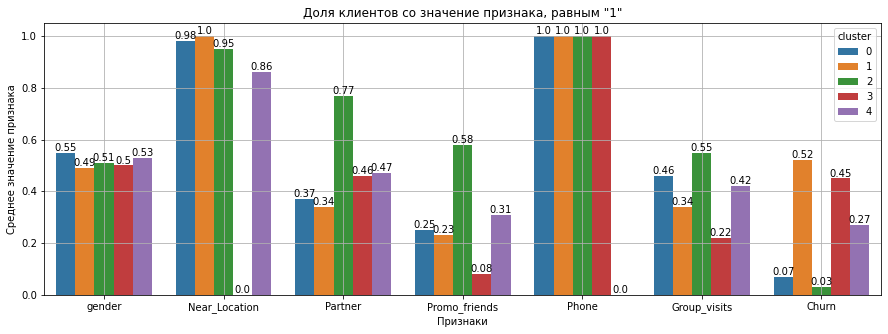

In [37]:
plt.figure(figsize=(15,5))
ax = sns.barplot(x="features", y="mean", hue="cluster", data=data_for_bar_clust)
autolabel(ax.patches, data_for_bar_clust['mean'], height_factor=1)
plt.ylabel('Среднее значение признака')
plt.xlabel('Признаки')
plt.title('Доля клиентов со значение признака, равным "1"')
plt.grid()
plt.show()

### Cтолбчатые диаграммы визуально повторяют те выводы, которые были сделаны на основе данных таблиц со средними значениями признаков.<a class='tocSkip'><br>

### Построим гистограммы и графики плотности распределения всех количественных признаков - оси у будет соответствовать плотность вероятности.<a class='tocSkip'>
Используем коэффициенты для того, чтобы одинаково разбивать значения на бины.

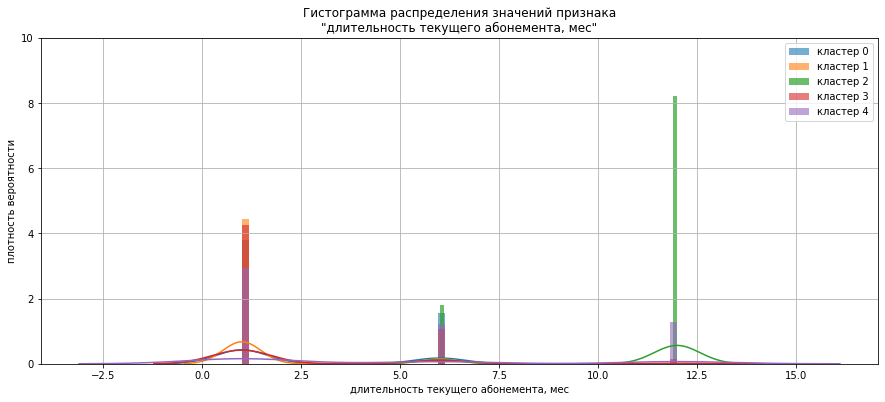

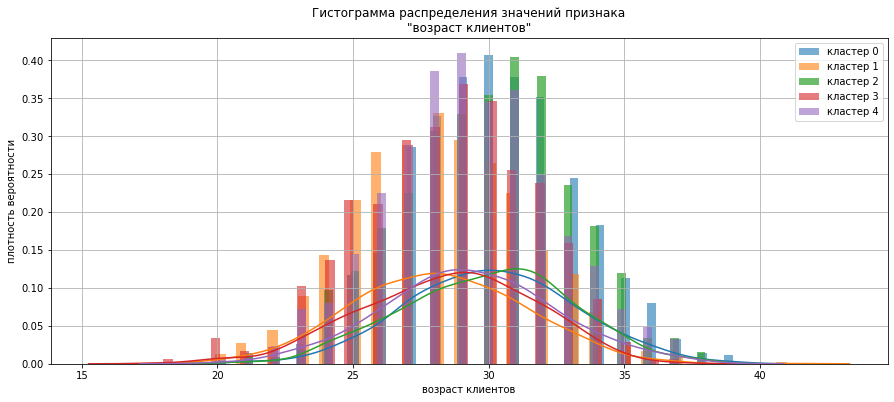

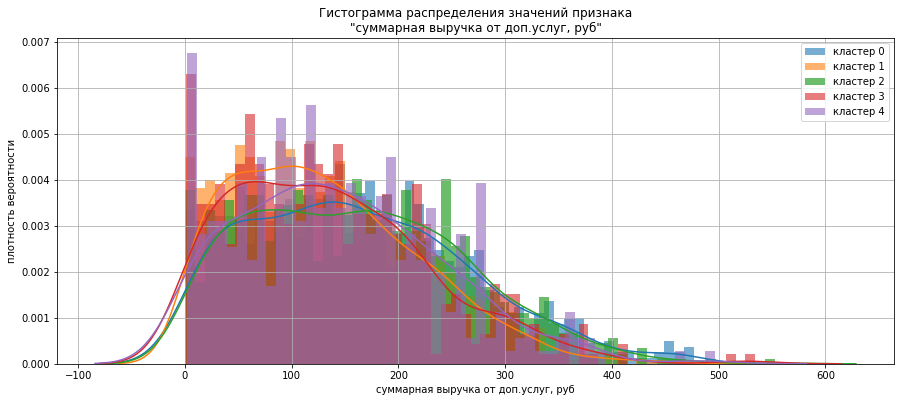

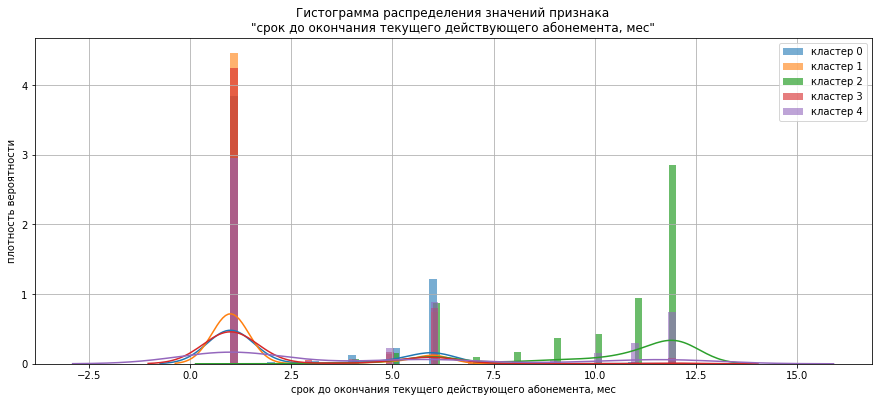

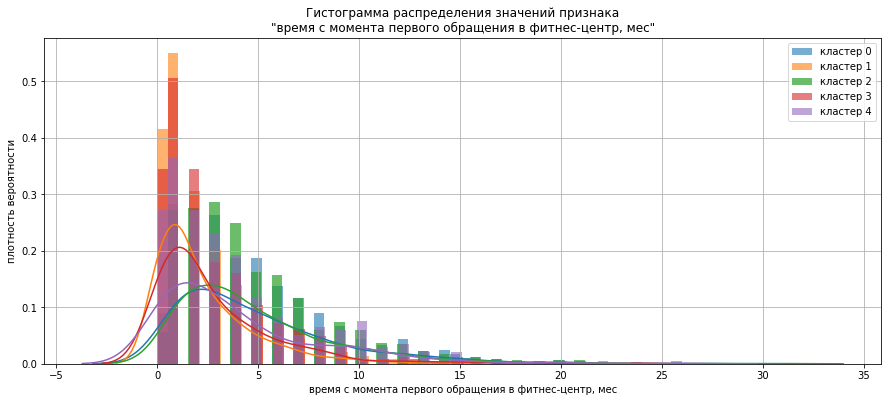

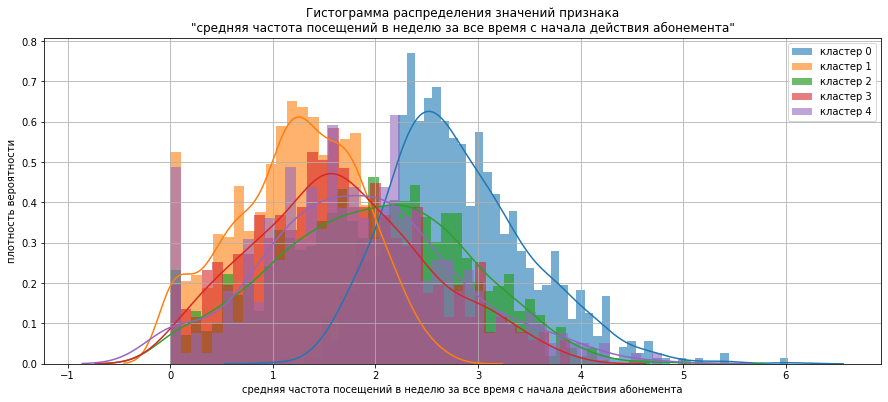

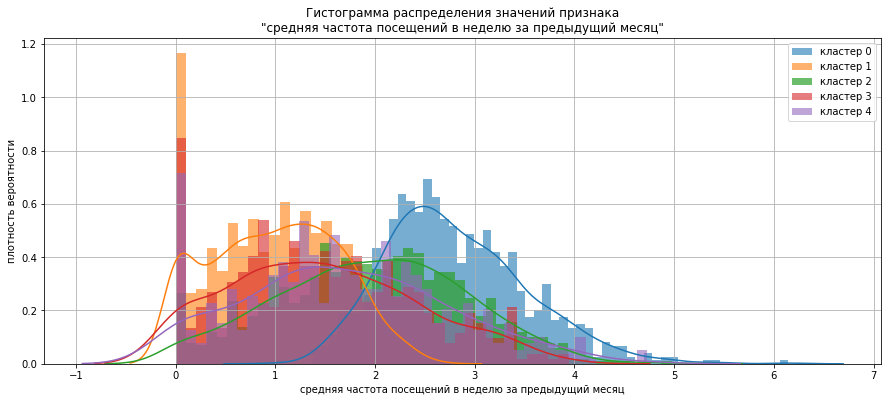

In [38]:
feature_qty_list=['Contract_period','Age','Avg_additional_charges_total','Month_to_end_contract','Lifetime','Avg_class_frequency_total','Avg_class_frequency_current_month']
feature_qty_names_list=['длительность текущего абонемента, мес','возраст клиентов','суммарная выручка от доп.услуг, руб','срок до окончания текущего действующего абонемента, мес','время с момента первого обращения в фитнес-центр, мес','средняя частота посещений в неделю за все время с начала действия абонемента','средняя частота посещений в неделю за предыдущий месяц']
data_clust_0=gym_churn[gym_churn['cluster']==0]
data_clust_1=gym_churn[gym_churn['cluster']==1]
data_clust_2=gym_churn[gym_churn['cluster']==2]
data_clust_3=gym_churn[gym_churn['cluster']==3]
data_clust_4=gym_churn[gym_churn['cluster']==4]
for i in range(0,7):
    plt.figure(figsize=(15,6))
    max_value=max(max(data_clust_0[feature_qty_list[i]]),max(data_clust_1[feature_qty_list[i]]),max(data_clust_2[feature_qty_list[i]]),max(data_clust_3[feature_qty_list[i]]),max(data_clust_4[feature_qty_list[i]]))
    koeff_0=max_value/max(data_clust_0[feature_qty_list[i]])
    koeff_1=max_value/max(data_clust_1[feature_qty_list[i]])
    koeff_2=max_value/max(data_clust_2[feature_qty_list[i]])
    koeff_3=max_value/max(data_clust_3[feature_qty_list[i]])   
    koeff_4=max_value/max(data_clust_4[feature_qty_list[i]])                                        
    sns.distplot(data_clust_0[feature_qty_list[i]], bins=int(60/koeff_0), hist_kws={'alpha':0.60}, label='кластер 0')
    sns.distplot(data_clust_1[feature_qty_list[i]], bins=int(60/koeff_1), hist_kws={'alpha':0.60}, label='кластер 1') 
    sns.distplot(data_clust_2[feature_qty_list[i]], bins=int(60/koeff_2), hist_kws={'alpha':0.70}, label='кластер 2') 
    sns.distplot(data_clust_3[feature_qty_list[i]], bins=int(60/koeff_3), hist_kws={'alpha':0.60}, label='кластер 3') 
    sns.distplot(data_clust_4[feature_qty_list[i]], bins=int(60/koeff_4), hist_kws={'alpha':0.60}, label='кластер 4')  
    plt.ylabel('плотность вероятности')
    if i==0:
        plt.ylim(0,10)
    plt.xlabel(feature_qty_names_list[i])
    plt.title('Гистограмма распределения значений признака\n"'+feature_qty_names_list[i]+'"')
    plt.legend()
    plt.grid()
    plt.show()

### Вывод по гистограммам:<a class='tocSkip'>
1. По клиентам кластеров № 0 и 2:
    1. Преобладающее большинство клиентов кластера № 2 покупают длительные абонементы (на 12 мес) - соответственно до конца действующего абонемента остается более 1 месяца. Клиенты кластера №0 в основной своей массе предпочитают приобретать абонементы не дольше, чем на 6 месяцев - соответственно до конца действующего абонемента у них остается не более 1-6 месяцев;
    2. Группы с самым старшим средним возрастом из всех кластеров - около 30 лет;
    3. В обоих кластерах примерно одинаково в среднем тратят на доп.услуги по 162 руб;
    4. В среднем в фитнес-центр обратились раньше, чем клиенты из остальных трех кластеров;
    5. Клиенты кластера № 0 - самые большие любители спорта - они ходят в фитнес-клуб 2-3 раза в неделю. Клиенты из кластера № 2 - чуть поленивее - они посещают клуб около 2-ух раз в неделю;<br><br>
    
2. По клиентам кластеров № 1 и 3:
    1. Преобладающее большинство клиентов этих кластеров выбирают краткосрочные месячные абонементы - соответственно до конца действующего абонемента у них остается не более 1 месяца;
    2. Группы с самым младшим средним возрастом из всех кластеров - около 28-29 лет;
    3. В обоих кластерах примерно одинаково в среднем тратят на доп.услуги по 120-135 руб - меньше, чем в остальных трех кластерах;
    4. В среднем в фитнес-центр обратились позже, чем клиенты из остальных трех кластеров - не ранее, чем 2 месяца назад;
    5. Показывают худшие показатели по еженедельной посещаемости, чем клиенты из остальных кластеров - нерегулярно 1-2 раза в неделю;    <br><br>
    
3. Клиенты кластера № 4 по средним значениям признаков занимают промежуточное положение между клиентами кластеров с минимальным и максимальным оттоком: 
    1. Преобладающее большинство клиентов выбирают краткосрочные месячные абонементы - соответственно до конца действующего абонемента у них остается не более 1 месяца;
    2. По возрасту - группа промежуточная между предыдущими двумя рассмотренными группами - средний возраст участников 29 лет;
    3. Занимает промежуточное положение по тратам клиентов на доп.услуги - 140 руб;
    4. Занимает промежуточное положение по времени первого обращения клиентов в клуб - бОльшая часть участников не ранее, чем 3 месяца назад;
    5. Показывают средние показатели по еженедельной посещаемости - лучшие, чем клиенты из кластеров с максимальным оттоком, но худшие, чем клиенты из групп с минимальным оттоком - 1-2 раза в неделю.

## Выводы:<a class='tocSkip'>
1. По клиентам кластеров № 0 и 2:
    1. Преобладающее большинство клиентов кластера № 2 покупают длительные абонементы (на 12 мес) - соответственно до конца действующего абонемента остается более 1 месяца. Клиенты кластера №0 в основной своей массе предпочитают приобретать абонементы не дольше, чем на 6 месяцев - соответственно до конца действующего абонемента у них остается не более 1-6 месяцев;
    2. Группы с самым старшим средним возрастом из всех кластеров - около 30 лет;
    3. В обоих кластерах примерно одинаково в среднем тратят на доп.услуги по 162 руб;
    4. В среднем в фитнес-центр обратились раньше, чем клиенты из остальных трех кластеров;
    5. Клиенты кластера № 0 - самые большие любители спорта - они ходят в фитнес-клуб 2-3 раза в неделю. Клиенты из кластера № 2 - чуть поленивее - они посещают клуб около 2-ух раз в неделю;
    6. Доля женщин в этих группах чуть больше, чем в других кластерах: кластер № 2 - 51%, кластер № 0 - 56%;
    7. Доля клиентов, живущих или работающих рядом с фитнес-клубом близка к 100%;
    8. В кластере № 2 78% клиентов, которые являются сотрудниками компании-партнёра клуба, в кластере № 0 - примерно на уровне оставшихся групп - 36%;
    9. По признаку факта первоначальной записи в рамках акции «приведи друга» различие более, чем в 2 раза между кластерами: кластер № 2 - 58%, кластер № 0 - 24%;
    10. Все клиенты кластеров оставили номера контактных телефонов;
    11. Около 50 % клиентов кластеров посещают групповые занятия;
    12. Для кластеров характерен минимальный отток клиентов - кластеры № 0 и 2 - 7 и 3% соответственно.
<br><br>    
2. По клиентам кластеров № 1 и 3:
    1. Преобладающее большинство клиентов этих кластеров выбирают краткосрочные месячные абонементы - соответственно до конца действующего абонемента у них остается не более 1 месяца;
    2. Группы с самым младшим средним возрастом из всех кластеров - около 28-29 лет;
    3. В обоих кластерах примерно одинаково в среднем тратят на доп.услуги по 120-135 руб - меньше, чем в остальных трех кластерах;
    4. В среднем в фитнес-центр обратились позже, чем клиенты из остальных трех кластеров - не ранее, чем 2 месяца назад;
    5. Показывают худшие показатели по еженедельной посещаемости, чем клиенты из остальных кластеров - нерегулярно 1-2 раза в неделю;    
    6. Доля женщин в этих группах чуть больше, чем в других кластерах: кластер № 1 - 48%, кластер № 3 - 49%;
    7.Любопытно, что, хотя для кластеров № 1 и 3 характерен максимальный отток. но в кластере № 3 вообще нет клиентов, которые живут или работают поблизости от клуба, в то время, как в кластере № 1 100% таких клиентов;
    8. Меньше половины клиентов являются сотрудниками компании-партнёра клуба - 35-46%;
    9. По признаку факта первоначальной записи в рамках акции «приведи друга» различие более, чем в 2 раза между кластерами: кластер № 1 - 24%, кластер № 3 - 8%;
    10. Все клиенты кластеров оставили номера контактных телефонов;
    11. Менее 50 % клиентов кластеров посещают групповые занятия: кластер № 1 - 34%, кластер № 3 - 22%;
    12. Для кластеров характерен максимальный отток клиентов - кластеры № 1 и 3 - 52 и 45% соответственно.
<br><br>    
3. Клиенты кластера № 4 по средним значениям признаков занимают промежуточное положение между клиентами кластеров с минимальным и максимальным оттоком. В части признаков они напоминают клиентов кластеров № 0 и 2, а в части - клиентов кластеров №1 и 3: 
    1. Преобладающее большинство клиентов выбирают краткосрочные месячные абонементы - соответственно до конца действующего абонемента у них остается не более 1 месяца;
    2. По возрасту - группа промежуточная между предыдущими двумя рассмотренными группами - средний возраст участников 29 лет;
    3. Занимает промежуточное положение по тратам клиентов на доп.услуги - 140 руб;
    4. Занимает промежуточное положение по времени первого обращения клиентов в клуб - бОльшая часть участников не ранее, чем 3 месяца назад;
    5. Показывают средние показатели по еженедельной посещаемости - лучшие, чем клиенты из кластеров с максимальным оттоком, но худшие, чем клиенты из групп с минимальным оттоком - 1-2 раза в неделю;
    6. Женщин в группе больше половины - 53%;
    7. Доля клиентов, живущих или работающих рядом с фитнес-клубом, составляет 86%;
    8. 47% клиентов являются сотрудниками компании-партнёра клуба;
    9. Доля клиентов, использовавших промо-код от знакомого при оплате первого абонемента, составляет 31%;
    10. Всех клиентов, не пожелавших оставить номер контактного телефона алгоритм отправил в кластер № 4;
    11. 42% клиентов кластера посещают групповые занятия;
    12. Отток клиентов имеет промежуточную величину между аналогичными значениями остальных кластеров - 27%

## 5. Выводы и базовые рекомендации по работе с клиентами<a id="step5"></a> 

1. В ходе проведенной работы были созданы две модели прогнозирования оттока клиентов - на основе алгоритмов логистической регрессии и случайного леса. Логистическая регрессия показала лучшие результаты, чем случайный лес. Вероятно, при более тонкой настройке модели случайного леса (количество деревьев, число объектов в листьях и т.д.) можно было бы добиться лучших результатов. В данном случае наиболее важным показателем представляется полнота Recall, поскольку нам нужно обнаружить по-максимуму всех клиентов, которые потенциально могут уйти в отток. Наилучшее значение этого показателя (0,83) достигается при использовании всех представленных в исходной таблице признаков в модели логистической регрессии и означает, что из 100 определенных моделью клиентов, которые потенциально могут уйти в отток, на самом деле покинут клуб 83 человека. Улучшить значение данной метрики можно путем снижения порога, с которым сравнивается вероятность отнесения конкретного клиента к  классу ушедших в отток.<br><br>
2. В процессе кластеризации все клиенты клуба были разделены на 5 групп:<br> 
    1. Клиенты, которые в наименьшей степени склонны к оттоку (кластер № 2 - в отток уходит только 3%):
        1. Покупают длительные абонементы (на 12 мес) - соответственно до конца действующего абонемента остается более 1 месяца;
        2. Средний возраст - около 30 лет;
        3. В среднем тратят на доп.услуги 162 руб;
        4. Более половины из них обратились в фитнес-центр не позднее 4 месяцев тому назад ;
        5. Посещают клуб около 2-ух раз в неделю;
        6. Среди них доля клиентов, живущих или работающих рядом с фитнес-клубом близка к 100%;
        7. 78% из этих клиентов являются сотрудниками компании-партнёра клуба;
        8. Более половины (58%) клиентов этой группы изначально пришли в клуб в рамках акции «приведи друга»
        9. Все клиенты  оставили номера контактных телефонов;
        10. Около 50 % клиентов посещают групповые занятия;
<br><br> 
    2. Клиенты, которые также в очень малой степени склонны к оттоку (кластер № 0 - в отток уходит только 7%):
        1. В основной своей массе предпочитают приобретать абонементы не дольше, чем на 6 месяцев - соответственно до конца действующего абонемента у них остается не более 1-6 месяцев;
        2. Средний возраст - около 30 лет;
        3. В среднем тратят на доп.услуги 162 руб;
        4. Более половины из них обратились в фитнес-центр не позднее 4 месяцев тому назад ;
        5. Самые большие любители спорта - они ходят в фитнес-клуб 2-3 раза в неделю.
        6. Среди них доля клиентов, живущих или работающих рядом с фитнес-клубом близка к 100%;
        7. 36% из этих клиентов являются сотрудниками компании-партнёра клуба;
        8. Только 24% от клиентов этой группы изначально пришли в клуб в рамках акции «приведи друга»;
        9. Все клиенты  оставили номера контактных телефонов;
        10. Около 50 % клиентов посещают групповые занятия;
<br><br> 
    3. Клиенты, которые в наибольшей степени склонны к оттоку (кластер № 1 - в отток уходит 52%):
        1. Преобладающее большинство клиентов выбирают краткосрочные месячные абонементы - соответственно до конца действующего абонемента у них остается не более 1 месяца;
        2. Средний возраст - около 28-29 лет;
        3. В среднем тратят на доп.услуги 120-135 руб;
        4. В среднем в фитнес-центр обратились не ранее, чем 2 месяца назад;
        5. Посещают клуб нерегулярно 1-2 раза в неделю;    
        6. Все эти клиенты живут или работают поблизости от клуба;
        7. Меньше половины из этих клиентов являются сотрудниками компании-партнёра клуба - 35-46%;
        8. Только 24% от клиентов этой группы изначально пришли в клуб в рамках акции «приведи друга»;
        9. Все клиенты оставили номера контактных телефонов;
        10. Только 34 % клиентов посещают групповые занятия;
<br><br>  
    4. Клиенты, которые также в большой степени склонны к оттоку (кластер № 3 - в отток уходит 45%):
        1. Преобладающее большинство клиентов выбирают краткосрочные месячные абонементы - соответственно до конца действующего абонемента у них остается не более 1 месяца;
        2. Средний возраст - около 28-29 лет;
        3. В среднем тратят на доп.услуги 120-135 руб;
        4. В среднем в фитнес-центр обратились не ранее, чем 2 месяца назад;
        5. Посещают клуб нерегулярно 1-2 раза в неделю;    
        6. Никто из этих клиентов не живет и не работет поблизости от клуба;
        7. Меньше половины из этих клиентов являются сотрудниками компании-партнёра клуба - 35-46%;
        8. Только 8% от клиентов этой группы изначально пришли в клуб в рамках акции «приведи друга»;
        9. Все клиенты оставили номера контактных телефонов;
        10. Только 22 % клиентов посещают групповые занятия;
<br><br>    
    5. Клиенты со средними значениями признаков - занимают промежуточное положение между клиентами кластеров с минимальным и максимальным оттоком (кластер № 3 - в отток уходит 27%):
        1. Преобладающее большинство клиентов выбирают краткосрочные месячные абонементы - соответственно до конца действующего абонемента у них остается не более 1 месяца;
        2. По возрасту - группа промежуточная между предыдущими двумя рассмотренными группами - средний возраст участников 29 лет;
        3. Занимает промежуточное положение по тратам клиентов на доп.услуги - 140 руб;
        4. Занимает промежуточное положение по времени первого обращения клиентов в клуб - бОльшая часть участников не ранее, чем 3 месяца назад;
        5. Показывают средние показатели по еженедельной посещаемости - лучшие, чем клиенты из кластеров с максимальным оттоком, но худшие, чем клиенты из групп с минимальным оттоком - 1-2 раза в неделю;
        6. Доля клиентов, живущих или работающих рядом с фитнес-клубом, составляет 86%;
        7. 47% клиентов являются сотрудниками компании-партнёра клуба;
        8. Доля клиентов, использовавших промо-код от знакомого при оплате первого абонемента, составляет 31%;
        9. Всех клиентов, не пожелавших оставить номер контактного телефона алгоритм отправил в кластер № 4;
        10. 42% клиентов кластера посещают групповые занятия;
<br><br>         
3. В качестве целевых групп логично выбрать клиентов из кластеров № 1 и 3, как в наибольшей степени склонных к оттоку. Соответственно, чтоб попытаться предотвратить их отток, можно разработать для этих клиентов ряд специальных предложений:
    - предложения по покупке абонементов на сроки 6 и 12 месяцев с привлекательной скидкой;
    - абонементы с особыми, более выгодными условиями (например, с увеличенным количеством входящих в абонемент индивидуальных занятий с тренером для того, чтобы заставить клиентов чаще ходить в спортзал);
    - специальные предложения/скидки на дополнительные услуги, предоставляемые фитнес-клубом.